<a href="https://colab.research.google.com/github/MarcoParola/medical_images_classification/blob/main/Pretrained_CNN_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import collections 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import optimizers

In [ ]:
projectPath = 'drive/MyDrive/Colab Notebooks/cidl/'
dataPath = 'numpy data/'

In [ ]:
%cd $projectPath
%run utils.ipynb
%cd '../../../..'

/content/drive/.shortcut-targets-by-id/1H_qsSPBi-K_nGcMzSsNcwFkqtAHG8iYD/cidl
/content


In [ ]:
# load data
imagesTrainPub, labelsTrainPub, imagesTestPub, labelsTestPub, imagesTestPriv = load_data(projectPath + dataPath)

# normalize data 
imagesTrainPub = scaleData(imagesTrainPub)
imagesTestPub = scaleData(imagesTestPub)

In [ ]:
# create (if not exists) the folder to store the models
dir_name = 'models/task3_1/'
if not os.path.exists(projectPath + dir_name):
  os.makedirs(projectPath + dir_name)

In [ ]:
np.random.seed(33)


# **Task 3**

## 3.1 Binary calssification: Mass and Calcification
Classes:
*   Mass 1218
*   Calcification 1458

In [ ]:
# 0 -> mass
# 1 -> calcification

# prepare trainig-set
trainingSet = []
trainingLabels = []

for i in range(len(labelsTrainPub)):
  if labelsTrainPub[i] == 1 or labelsTrainPub[i] == 2:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(0)
  if labelsTrainPub[i] == 3 or labelsTrainPub[i] == 4:
    trainingSet.append(imagesTrainPub[i])
    trainingLabels.append(1)

trainingSet = np.array(trainingSet)
trainingSet = trainingSet.reshape(2676, 150, 150, 1)

training = []
for i in range(len(trainingSet)):
  training.append((trainingSet[i], trainingLabels[i]))

training = np.array(training)
np.random.shuffle(training)


trainingSet = []
trainingLabels = []

for i in range(len(training)):
  trainingSet.append(training[i][0])
  trainingLabels.append(training[i][1])

trainingSet = np.array(trainingSet)
trainingLabels = np.array(trainingLabels)

# prepare test-set
testSet = []
testLabels = []

for i in range(len(labelsTestPub)):
  if labelsTestPub[i] == 1 or labelsTestPub[i] == 2:
    testSet.append(imagesTestPub[i])
    testLabels.append(0)
  if labelsTestPub[i] == 3 or labelsTestPub[i] == 4:
    testSet.append(imagesTestPub[i])
    testLabels.append(1)

testSet = np.array(testSet)
testSet = testSet.reshape(336, 150, 150, 1)

# the output must have a categorigal values
testLabelsCategorical = to_categorical(np.array(testLabels))
trainingLabelsCategorical = to_categorical(np.array(trainingLabels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# **Augment Data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
dataGenerator = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=20,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='reflect')


augmentedData = []
augmentedLabels = []

for j in range(0,len(trainingSet)):
  for i in range(0,4):
    dataGenerated = dataGenerator.flow(trainingSet[j].reshape(1,150,150,1), batch_size=4)
    augmentedData.append(dataGenerated[0].reshape(150, 150))
    augmentedLabels.append(trainingLabels[j])
    del dataGenerated

augmentedLabels = to_categorical((np.array(augmentedLabels)))

augmentedData = np.array(augmentedData)
augmentedData = augmentedData.reshape(len(augmentedData), 150, 150, 1)
print(augmentedData.shape, augmentedLabels.shape)


(10704, 150, 150, 1) (10704, 2)


In [ ]:
# trick to use the pretrained network on gray scale immages
trainingSet = np.repeat(trainingSet,3, axis = 3)
testSet = np.repeat(testSet,3, axis = 3)

augmentedData = np.repeat(augmentedData,3, axis = 3)
augmentedLabelsCategorical = to_categorical(augmentedLabels)

# **VGG16**
We test VGG16 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.87      0.91      0.89       179
           1       0.89      0.85      0.87       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336

11/11 [==============================] - 1s 62ms/step - loss: 0.2983 - accuracy: 0.8810
0.29828619956970215 0.8809523582458496


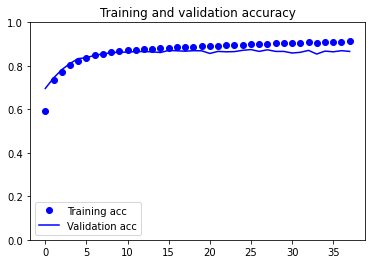

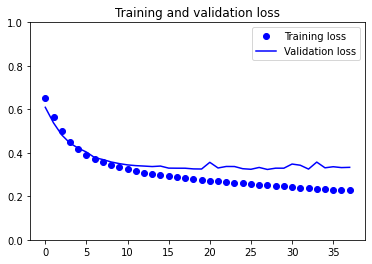

[0 1]
Normalized confusion matrix


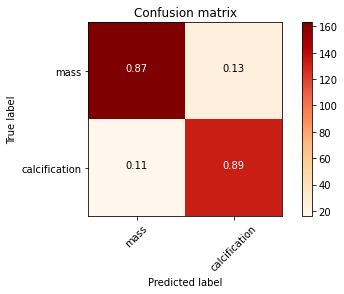

In [ ]:
from tensorflow.keras.applications import VGG16

tf.random.set_seed(7)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


# add fully connected layers as classifier
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(2, activation='sigmoid'))



#lr=2e-5
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model1.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model1.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model1.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model1, testSet, testLabels, ['mass', 'calcification'])

# use to plot
model1_1 = model1

# **VGG16-Feature Extraction**

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.81      0.88      0.85       179
           1       0.85      0.77      0.81       157

    accuracy                           0.83       336
   macro avg       0.83      0.83      0.83       336
weighted avg       0.83      0.83      0.83       336

11/11 [==============================] - 1s 62ms/step - loss: 0.3738 - accuracy: 0.8304
0.37380021810531616 0.8303571343421936


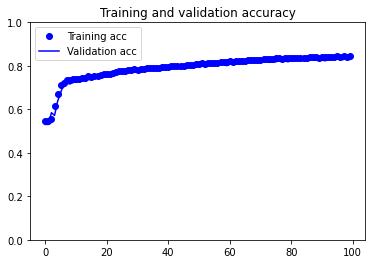

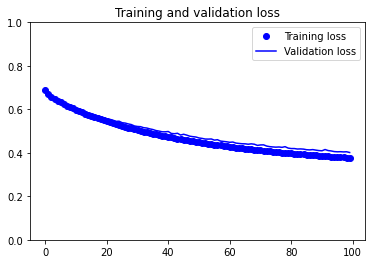

[0 1]
Normalized confusion matrix


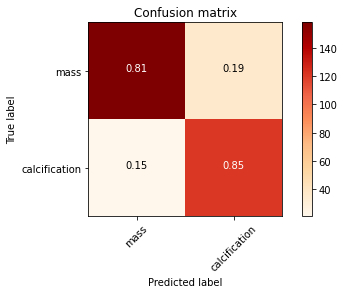

In [ ]:
from tensorflow.keras.applications import VGG16

tf.random.set_seed(7)
#import pretrained model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = False



# add fully connected layers as classifier
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(2, activation='sigmoid'))



#lr=2e-5
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model1.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model1.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model1.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model1, testSet, testLabels, ['mass', 'calcification'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


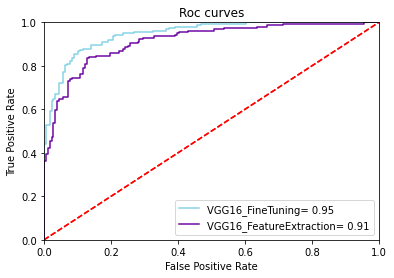

In [ ]:
models = [model1_1, model1]

plotRocCurves(models, testSet, testLabels, ['VGG16_FineTuning', 'VGG16_FeatureExtraction'])

# **VGG19**
We test VGG19 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       179
           1       0.85      0.86      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336

11/11 [==============================] - 1s 75ms/step - loss: 0.3346 - accuracy: 0.8631
0.33462968468666077 0.863095223903656


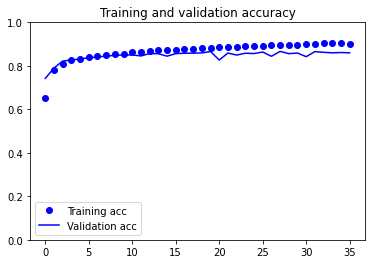

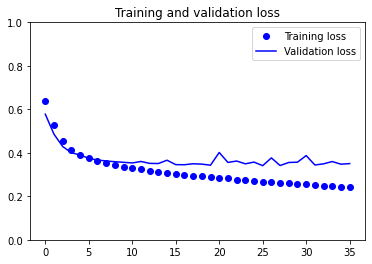

[0 1]
Normalized confusion matrix


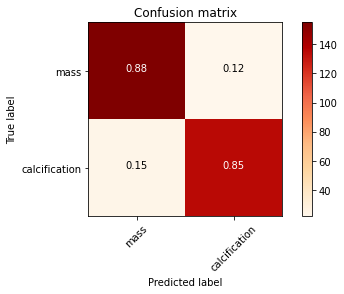

In [ ]:
from tensorflow.keras.applications import VGG19

tf.random.set_seed(7)
#import pretrained model
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# add fully connected layers as classifier
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(2, activation='sigmoid'))

#lr=2e-5
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model2.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model2.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model2.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model2, testSet, testLabels, ['mass', 'calcification'])

#use to plot
model2_1 = model2

# **VGG19-Feature Extraction**

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.81      0.83       179
           1       0.79      0.83      0.81       157

    accuracy                           0.82       336
   macro avg       0.82      0.82      0.82       336
weighted avg       0.82      0.82      0.82       336

11/11 [==============================] - 1s 74ms/step - loss: 0.4191 - accuracy: 0.8214
0.41909390687942505 0.8214285969734192


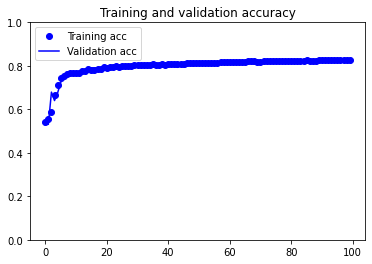

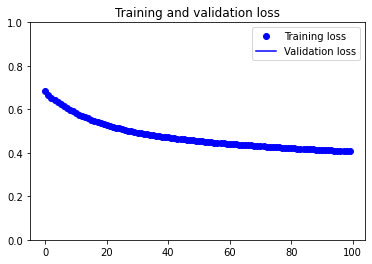

[0 1]
Normalized confusion matrix


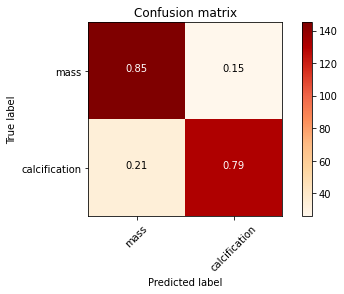

In [ ]:
from tensorflow.keras.applications import VGG19

tf.random.set_seed(7)
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

# Freeze layers
conv_base.trainable = False

# add fully connected layers as classifier
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(2, activation='sigmoid'))

#lr=2e-5
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 2e-6),
              metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model2.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model2.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model2.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model2, testSet, testLabels, ['mass', 'calcification'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


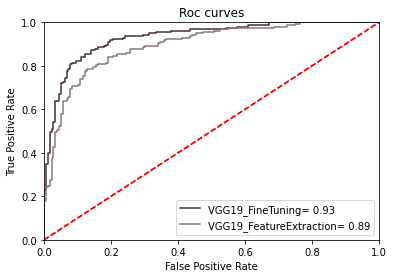

In [ ]:
models = [model2_1, model2]

plotRocCurves(models, testSet, testLabels, ['VGG19_FineTuning', 'VGG19_FeatureExtraction'])

# **ResNet50**

We test ResNet50 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       179
           1       0.91      0.73      0.81       157

    accuracy                           0.84       336
   macro avg       0.85      0.83      0.84       336
weighted avg       0.85      0.84      0.84       336

11/11 [==============================] - 1s 51ms/step - loss: 0.3897 - accuracy: 0.8393
0.3896752893924713 0.8392857313156128


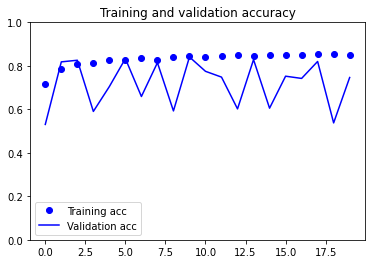

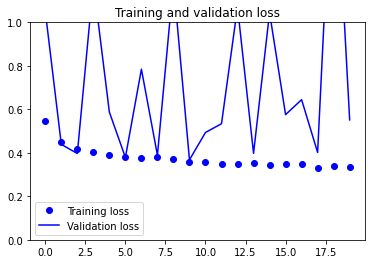

[0 1]
Normalized confusion matrix


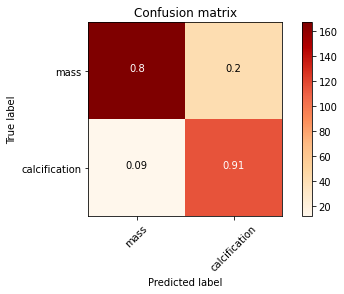

In [ ]:
from tensorflow.keras.applications import ResNet50

tf.random.set_seed(7) 

# pre-trained network
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# classifier
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(2, activation='sigmoid'))

model3.summary()



model3.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr=2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model3.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model3.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model3.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model3, testSet, testLabels, ['mass', 'calcification'])


model3_1 = model3

# **ResNet50-Feature Extraction**

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.56      0.66       179
           1       0.63      0.84      0.72       157

    accuracy                           0.69       336
   macro avg       0.72      0.70      0.69       336
weighted avg       0.72      0.69      0.69       336

11/11 [==============================] - 1s 50ms/step - loss: 0.6555 - accuracy: 0.6935
0.655468761920929 0.6934523582458496


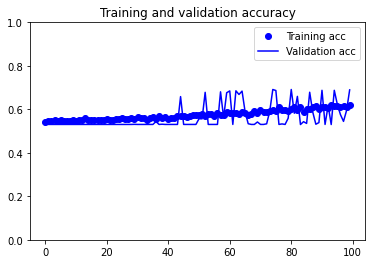

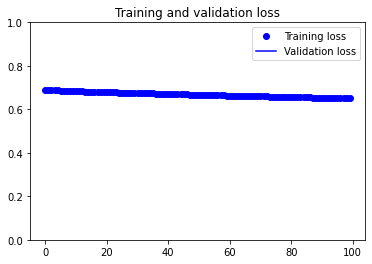

[0 1]
Normalized confusion matrix


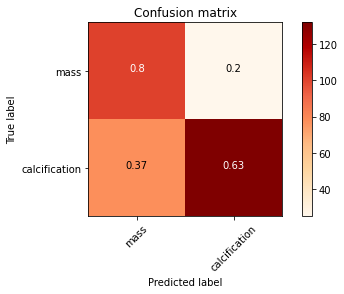

In [ ]:
from tensorflow.keras.applications import ResNet50

tf.random.set_seed(7)   

# pre-trained network
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

conv_base.trainable = False

# classifier
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(2, activation='sigmoid'))

model3.summary()



model3.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr=2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model3.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model3.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model3.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model3, testSet, testLabels, ['mass', 'calcification'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


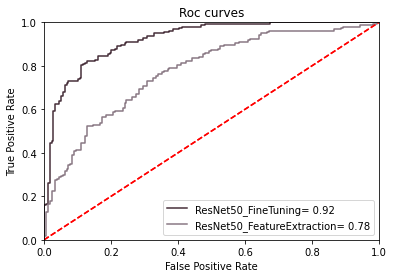

In [ ]:
models = [model3_1, model3]

plotRocCurves(models, testSet, testLabels, ['ResNet50_FineTuning', 'ResNet50_FeatureExtraction'])

# **InceptionV3**

We test InceptionV3 neural network trained on imagenet dataset, freezing different convolutional layer belonging to different blocks and appending different fully connected neural networks as classifier.

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       179
           1       0.88      0.83      0.85       157

    accuracy                           0.87       336
   macro avg       0.87      0.86      0.86       336
weighted avg       0.87      0.87      0.87       336

11/11 [==============================] - 0s 31ms/step - loss: 0.3288 - accuracy: 0.8661
0.3288238048553467 0.8660714030265808


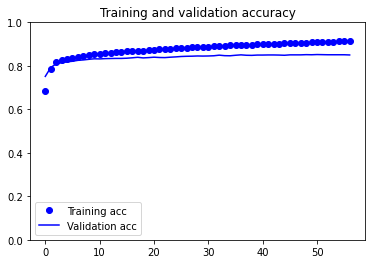

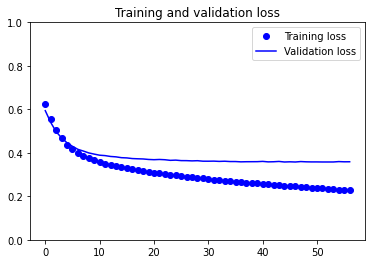

[0 1]
Normalized confusion matrix


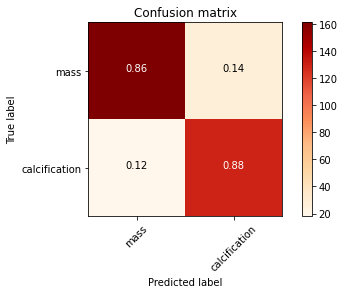

In [ ]:
from tensorflow.keras.applications import InceptionV3
  

# pre-trained network
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv2d_93':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# classifier
model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(2, activation='sigmoid'))


#lr=2e-5
model5.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr = 2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model5.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model5.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model5.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model5, testSet, testLabels, ['mass', 'calcification'])

#
model5_1 = model5


# **InceptionV3-Feature Extraction**

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.89      0.88       179
           1       0.87      0.84      0.86       157

    accuracy                           0.87       336
   macro avg       0.87      0.87      0.87       336
weighted avg       0.87      0.87      0.87       336

11/11 [==============================] - 0s 31ms/step - loss: 0.3268 - accuracy: 0.8690
0.3267638385295868 0.8690476417541504


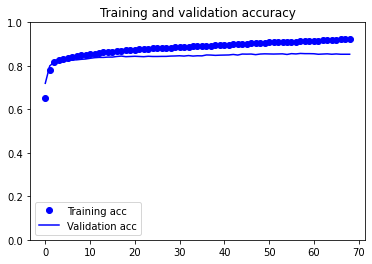

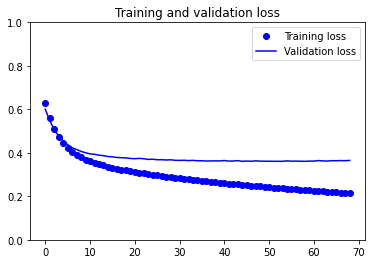

[0 1]
Normalized confusion matrix


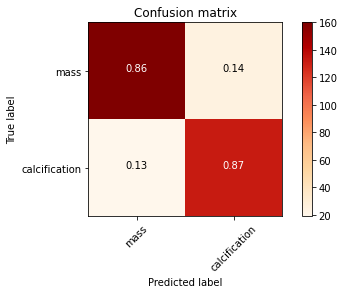

In [ ]:
from tensorflow.keras.applications import InceptionV3  

# pre-trained network
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

conv_base.trainable = False

# classifier
model5 = models.Sequential()
model5.add(conv_base)
model5.add(layers.Flatten())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dense(2, activation='sigmoid'))


#lr=2e-5
model5.compile(loss='binary_crossentropy',
      optimizer=optimizers.RMSprop(lr = 2e-6),
      metrics=['accuracy'])

earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

history = model5.fit(augmentedData, augmentedLabels, epochs=100, callbacks=[earlyStopCallback], batch_size=32, validation_split=0.2)

pred = model5.predict_classes(testSet)
print(metrics.classification_report(testLabels, pred))
test_loss, test_acc = model5.evaluate(testSet, testLabelsCategorical)
print(test_loss, test_acc)
plot_accurancy_loss(history)
plot_confusionMatrix(model5, testSet, testLabels, ['mass', 'calcification'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


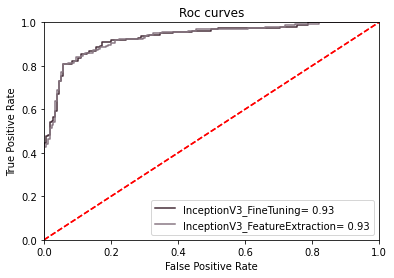

In [ ]:
models = [model5_1, model5]

plotRocCurves(models, testSet, testLabels, ['InceptionV3_FineTuning', 'InceptionV3_FeatureExtraction'])

# **Roc Curves for Fine Tuning models**

In [ ]:
VGG16 = model1_1
VGG19 = model2_1
ResNet50 = model3_1
InceptionV3 = model5_1

models = [VGG16, VGG19, ResNet50, InceptionV3]

plotRocCurves(models, testSet, testLabels, ['VGG16_FineTuning', 'VGG19_FineTuning', 'ResNet50_FineTuning', 'ResNet152_FineTuning', 'InceptionV3_FineTuning'])

In [ ]:
VGG16 = model1
VGG19 = model2
ResNet50 = model3
InceptionV3 = model5

models = [VGG16, VGG19, ResNet50, InceptionV3]

plotRocCurves(models, testSet, testLabels, ['VGG16_FeatureExtraction', 'VGG19_FeatureExtraction', 'ResNet50_FeatureExtraction', 'ResNet152_FeatureExtraction', 'InceptionV3_FeatureExtraction'])